## Auto reload

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LIB

In [2]:
%reload_ext autoreload

# Basic lib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.rcParams['font.family'] = ['Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

# config
import yaml

# Custom lib
from src.loader import Loader
from src.loan_preprocessor import Loan_Preprocessor
from src.log_preprocessor import Log_Preprocessor
from src.user_preprocessor import User_Preprocessor
from src.cofix_preprocessor import Cofix_Preprocessor
from src.matcher import Matcher
from src.sampling import down_sampling, check_imbalanced_label, split_train_valid
from src.mice import mice
from src.bank import Bank_info
from src.models.lgbm_model import LGBM
from src.models.xgb_model import XGB
from src.models.rf_model import RF

# ignore warnings
pd.set_option('mode.chained_assignment',  None)
plt.style.use('seaborn-whitegrid')

## Load Config

In [3]:
with open("config.yaml", 'r') as config_file:
    config_dict = yaml.load(config_file, Loader=yaml.FullLoader)

## Load Data

In [4]:
loader_config = config_dict.get('Loader')

In [5]:
loader_config = config_dict.get('Loader')
loader = Loader(loader_config)
loan_df = loader.run('loan_result.csv')
log_df = loader.run('log_data.csv')
user_df = loader.run('user_spec.csv')
cofix_df = loader.run('cofix.csv')

## Preprocess

In [6]:
prep_config = config_dict.get('Preprocessor')

# Loan preprocess
loan_preprocessor = Loan_Preprocessor(loan_df, prep_config)
prep_loan_df = loan_preprocessor.run(
    save_file_name='prep_loan.fth',
    save_mode=True
    )

필요 없는 열 삭제 중...
datetime으로 바꾸는 중...
결측치를 가지는 행 삭제 중...
✅ prep dataset saved at (data/prep/prep_loan.fth)


In [7]:
# Log preprocess
log_preprocessor = Log_Preprocessor(log_df, prep_config)
prep_log_df = log_preprocessor.run(
    save_file_name='prep_log.fth',
    save_mode=True
)

필요 없는 열 삭제 중...
datetime으로 바꾸는 중...
카테고리화 시키는 중...
시간축을 기준으로 정렬 중...
✅ prep dataset saved at (data/prep/prep_log.fth)


In [8]:
# User preprocess
user_preprocessor = User_Preprocessor(user_df, prep_config)
prep_user_df = user_preprocessor.run(
    save_file_name='prep_user.fth',
    save_mode=True
)

필요 없는 열 삭제 중...
datetime으로 바꾸는 중...
파생변수 생성 중...
카테고리화 시키는 중...
원핫인코딩 중...
순서형인코딩 중...
결측치를 가지는 행 삭제 중...
✅ prep dataset saved at (data/prep/prep_user.fth)


In [9]:
# cofix preprocess
cofix_preprocessor = Cofix_Preprocessor(cofix_df, prep_config)
prep_cofix_df = cofix_preprocessor.run(
    save_file_name='prep_cofix.fth',
    save_mode=True
)

대상기간 열 나누는 중...
datetime으로 바꾸는 중...
시간축을 기준으로 정렬 중...
COFIX 금리 열 이름 변경 중...
✅ prep dataset saved at (data/prep/prep_cofix.fth)


## Matcher

In [10]:
matcher_config = config_dict.get('Matcher')

In [11]:
matcher = Matcher(prep_user_df, prep_loan_df, prep_log_df, prep_cofix_df, matcher_config)

In [12]:
train_valid_df, test_df = matcher.run(save_mode=True)

Loan과 Cofix 매칭중...
Loan_Cofix와 User를 merge중...
Train(Valid)과 Test로 나누는 중...
✅ matched dataset saved at (data/match/ml_train_valid.fth)
✅ matched dataset saved at (data/match/ml_test.fth)


## MICE

In [13]:
# train
mice_train = mice(train_valid_df)
mice_train_df = mice_train.mice_1()

In [14]:
# test
mice_test = mice(test_df)
mice_test_df = mice_test.mice_1()

## Bank

In [15]:
bank_info = Bank_info(mice_train_df)
final_train_df, bank_info_df = bank_info.run()
bank_info = Bank_info(mice_test_df)
final_test_df, bank_info_df = bank_info.run()

## Resampling & Modeling

In [16]:
final_train_df = final_train_df[[
       'is_applied',
       'loan_limit', 'loan_rate', 'cofix_rate',
       'desired_amount', 'existing_loan_cnt',
       'gender_0.0', 'gender_1.0', 'gender_nan',
       'income_type_EARNEDINCOME', 'income_type_EARNEDINCOME2',
       'income_type_FREELANCER', 'income_type_OTHERINCOME',
       'income_type_PRACTITIONER', 'income_type_PRIVATEBUSINESS', 
       'employment_type_계약직', 'employment_type_기타',
       'employment_type_일용직', 'employment_type_정규직',
       'houseown_type_기타가족소유', 'houseown_type_배우자', 'houseown_type_자가',
       'houseown_type_전월세',
       'purpose_기타', 'purpose_대환대출',
       'purpose_사업자금', 'purpose_생활비', 'purpose_자동차구입', 'purpose_전월세보증금',
       'purpose_주택구입', 'purpose_투자',
       'personal_rehabilitation_yn_0.0', 'personal_rehabilitation_yn_1.0',
       'personal_rehabilitation_yn_nan', '소득분위', '근속정도', 'mice_credit_score',
       'mice_existing_loan_amt', 'mice_age_group', 'loanamt_per_income',
       'income_per_credit','loan_rate_per_cofix_rate','bank_label_0',
       'bank_label_1', 'bank_label_2'
       ]]

In [50]:
NUM_DOWN_SAMPLING = 30
f1_list = []

for sampling_idx in range(NUM_DOWN_SAMPLING):
    
    print(f'✅ Sampling #{sampling_idx}')
    
    # Resampling & split
    downsampled_df = down_sampling(final_train_df) # input을 mice_train_df 하면 될 것 같아요
    train_X, valid_X, train_Y, valid_Y = split_train_valid(downsampled_df)
    
    # Modeling with train set
    random_state = None
    model = LGBM(train_X, train_Y,valid_X, valid_Y, random_state)
    trained_model = model.model_train()
    
    # f1 score
    f1_score = model.val_score(trained_model)
    f1_list.append(f1_score)
    
    #model.confusion_matrix(trained_model)
    
    # permutation_importance
    #model.permutation_importance(trained_model)
    
    # feature_importance
    #model.feature_importance(trained_model)
    
    # shap
    #model.shap(trained_model)

✅ Sampling #0
Down Sampling 중...
Train과 Valid로 나누는 중...
✅ model_train
f1_score:  0.8023279293497907
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.80    110682
         1.0       0.79      0.83      0.81    111203

    accuracy                           0.80    221885
   macro avg       0.80      0.80      0.80    221885
weighted avg       0.80      0.80      0.80    221885

✅ Sampling #1
Down Sampling 중...
Train과 Valid로 나누는 중...
✅ model_train
f1_score:  0.8007944216965577
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79    110682
         1.0       0.78      0.83      0.81    111203

    accuracy                           0.80    221885
   macro avg       0.80      0.80      0.80    221885
weighted avg       0.80      0.80      0.80    221885

✅ Sampling #2
Down Sampling 중...
Train과 Valid로 나누는 중...
✅ model_train
f1_score:  0.801606445113394
              precision    recall  f1-score   s

<Figure size 800x600 with 0 Axes>

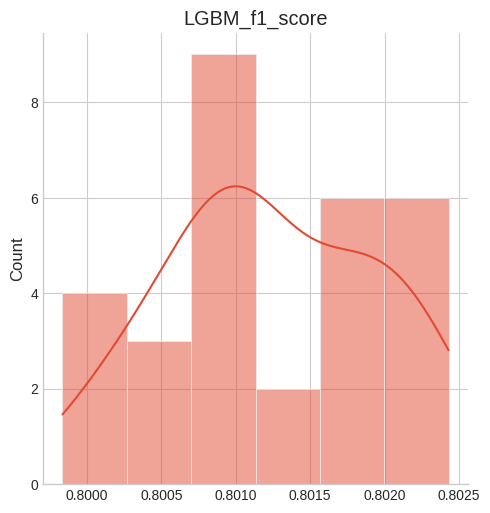

In [185]:
plt.figure(figsize=(8,6))
sns.displot(f1_list,kde=True)
plt.title('LGBM_f1_score')
plt.show()

## Inference

In [17]:
pred_train_df = final_train_df[[
    'purpose_전월세보증금',
    'purpose_생활비',
    'purpose_대환대출',
    'income_type_PRIVATEBUSINESS',
    '근속정도',
    'houseown_type_자가',
    'desired_amount',
    'bank_label_1',
    'personal_rehabilitation_yn_nan',
    'loan_rate_per_cofix_rate',
    'existing_loan_cnt',
    'mice_existing_loan_amt',
    'loan_limit',
    'loanamt_per_income',
    'purpose_주택구입',
    'income_type_EARNEDINCOME',
    'mice_credit_score',
    'cofix_rate',
    'bank_label_2',
    'loan_rate',
    '소득분위',
    'bank_label_0',
    'mice_age_group',
    'income_per_credit',
    'is_applied'
]]

In [18]:
pred_test_df = final_test_df[[
       'purpose_전월세보증금',
       'purpose_생활비',
       'purpose_대환대출',
       'income_type_PRIVATEBUSINESS',
       '근속정도',
       'houseown_type_자가',
       'desired_amount',
       'bank_label_1',
       'personal_rehabilitation_yn_nan',
       'loan_rate_per_cofix_rate',
       'existing_loan_cnt',
       'mice_existing_loan_amt',
       'loan_limit',
       'loanamt_per_income',
       'purpose_주택구입',
       'income_type_EARNEDINCOME',
       'mice_credit_score',
       'cofix_rate',
       'bank_label_2',
       'loan_rate',
       '소득분위',
       'bank_label_0',
       'mice_age_group',
       'income_per_credit'
       ]]

In [19]:
test_X = pred_test_df

In [21]:
import matplotlib
matplotlib.rcParams['font.family'] = ['Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

Down Sampling 중...
Train과 Valid로 나누는 중...
(887537, 24) (887537,)
(221885, 24) (221885,)
✅ model_train


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


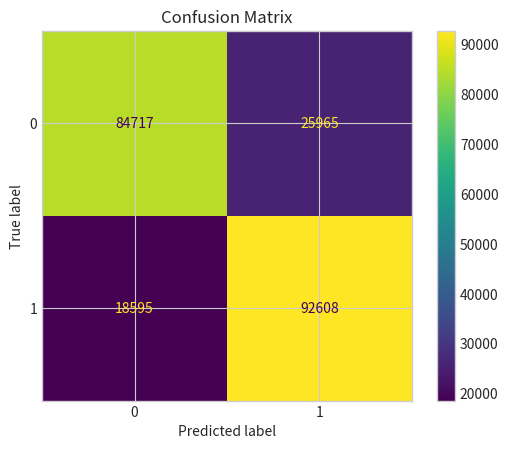

✅ permutation_importance


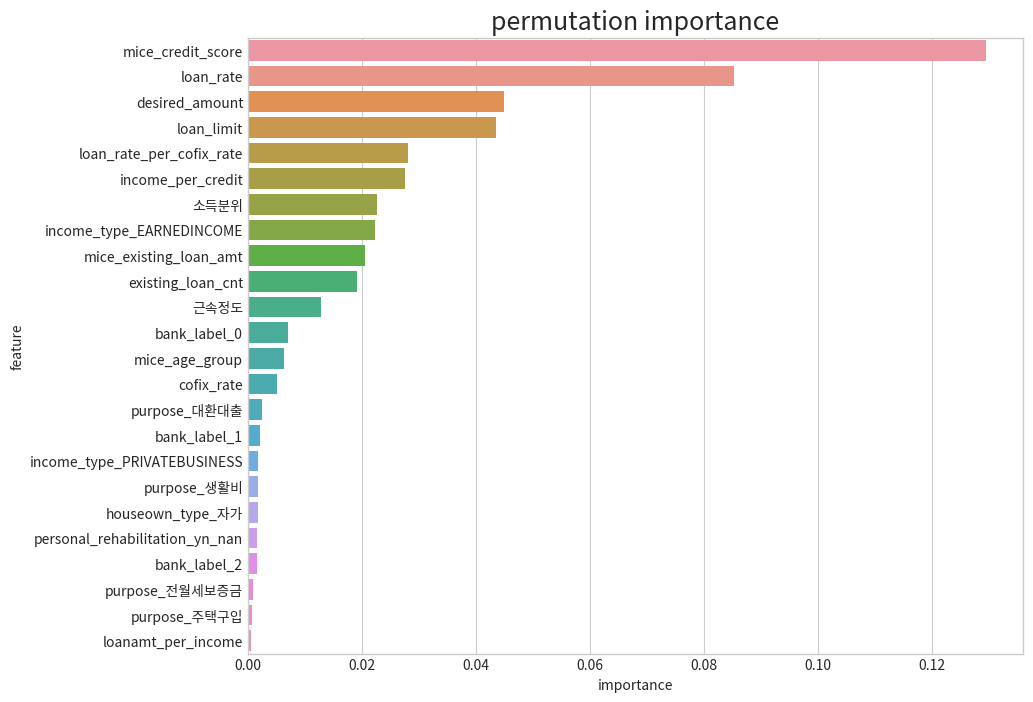

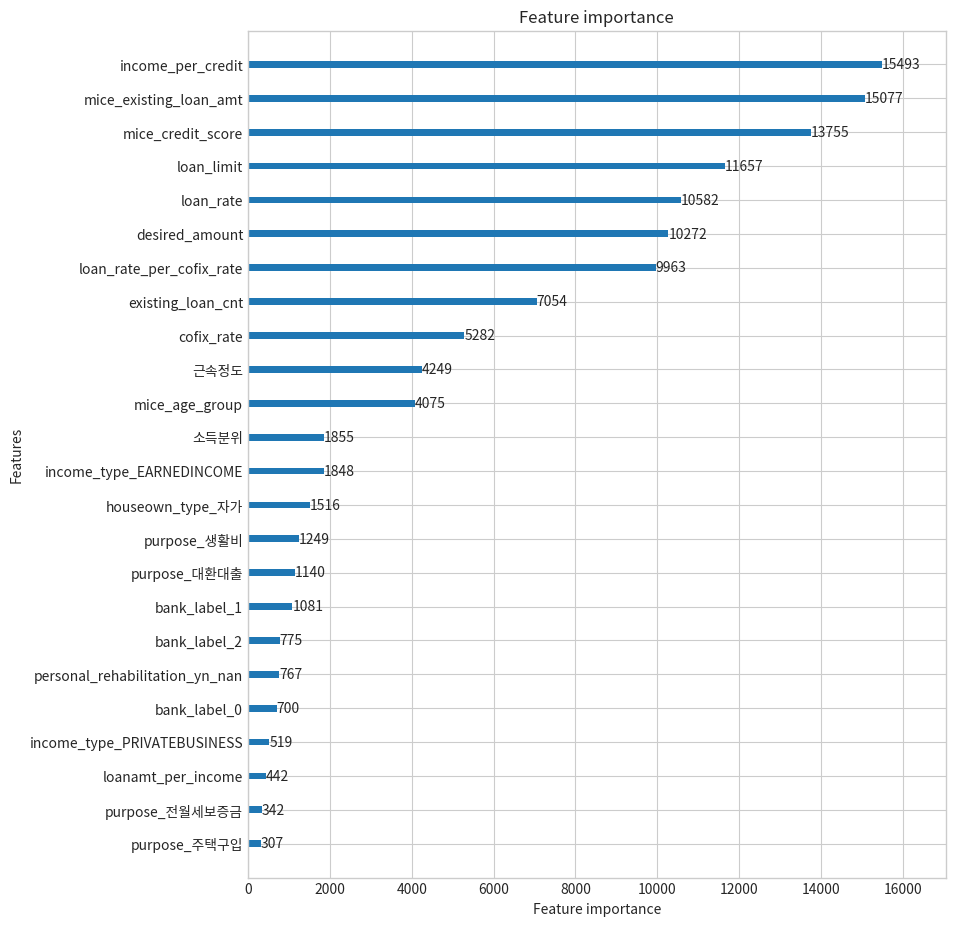

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


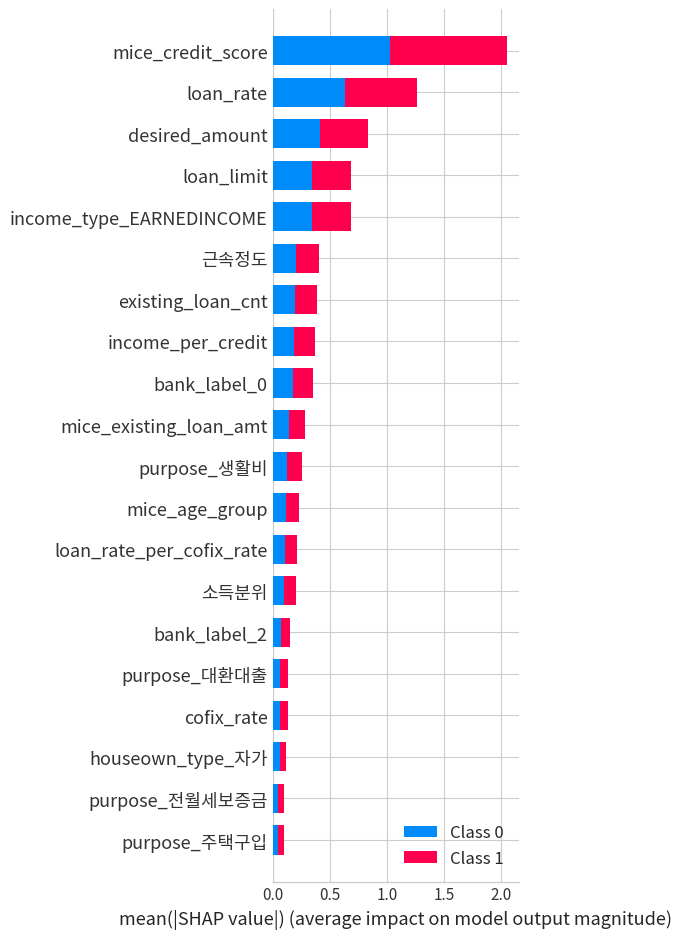

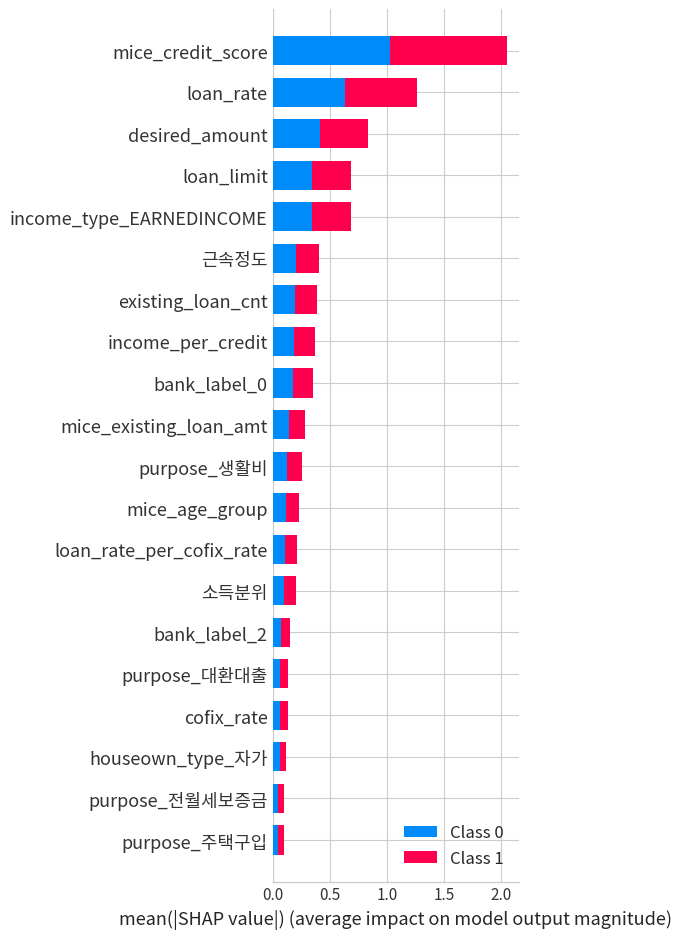

In [22]:
# 인퍼런스 & hard voting

# LGBM
downsampled_df = down_sampling(pred_train_df) 
train_X, valid_X, train_Y, valid_Y = split_train_valid(downsampled_df)
print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)

random_state = None
model = LGBM(train_X, train_Y,valid_X, valid_Y, random_state)
trained_model = model.model_train()
lgbm_pred = model.pred_testset(test_X,trained_model)
# confusion_matrix
model.confusion_matrix(trained_model)
# permutation_importance
model.permutation_importance(trained_model)
# feature_importance
model.feature_importance(trained_model)
# shap
model.shap(trained_model)

Down Sampling 중...
Train과 Valid로 나누는 중...
(887537, 24) (887537,)
(221885, 24) (221885,)
✅ model_train


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


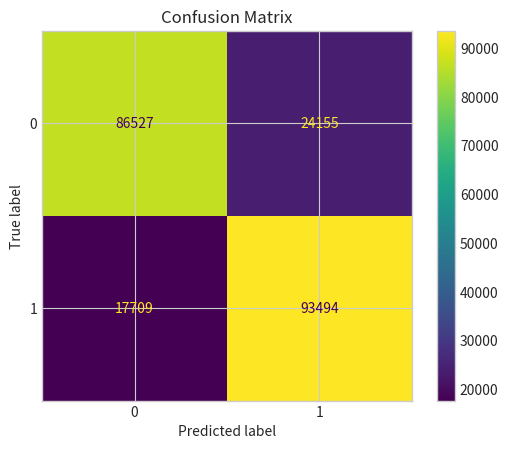

✅ permutation_importance


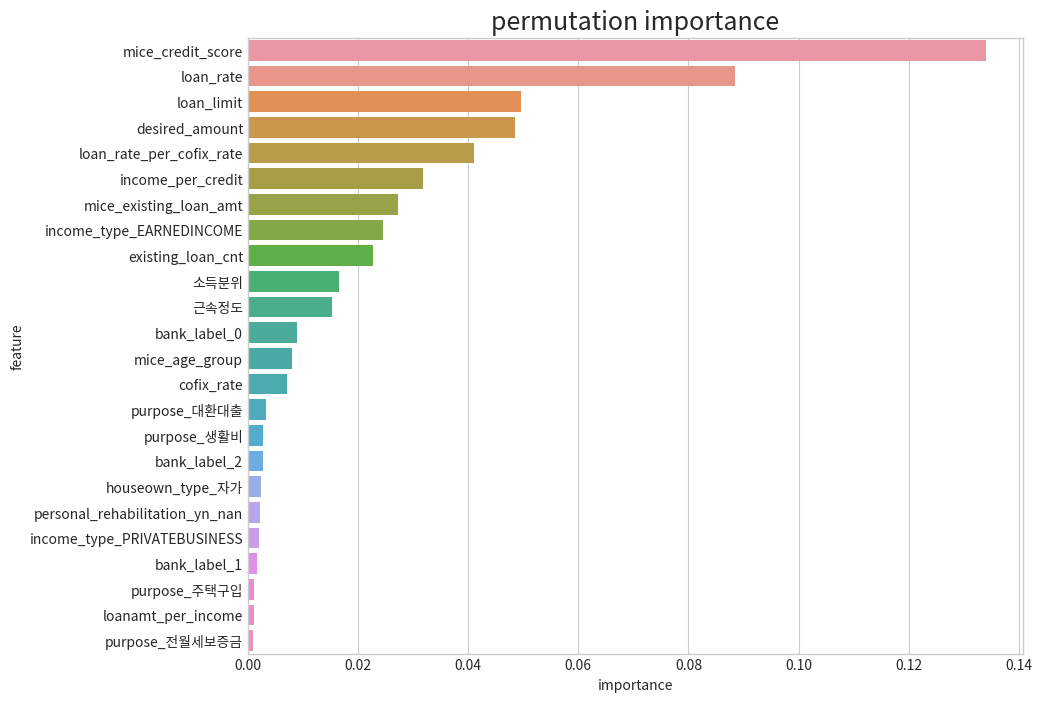

✅ feature_importance


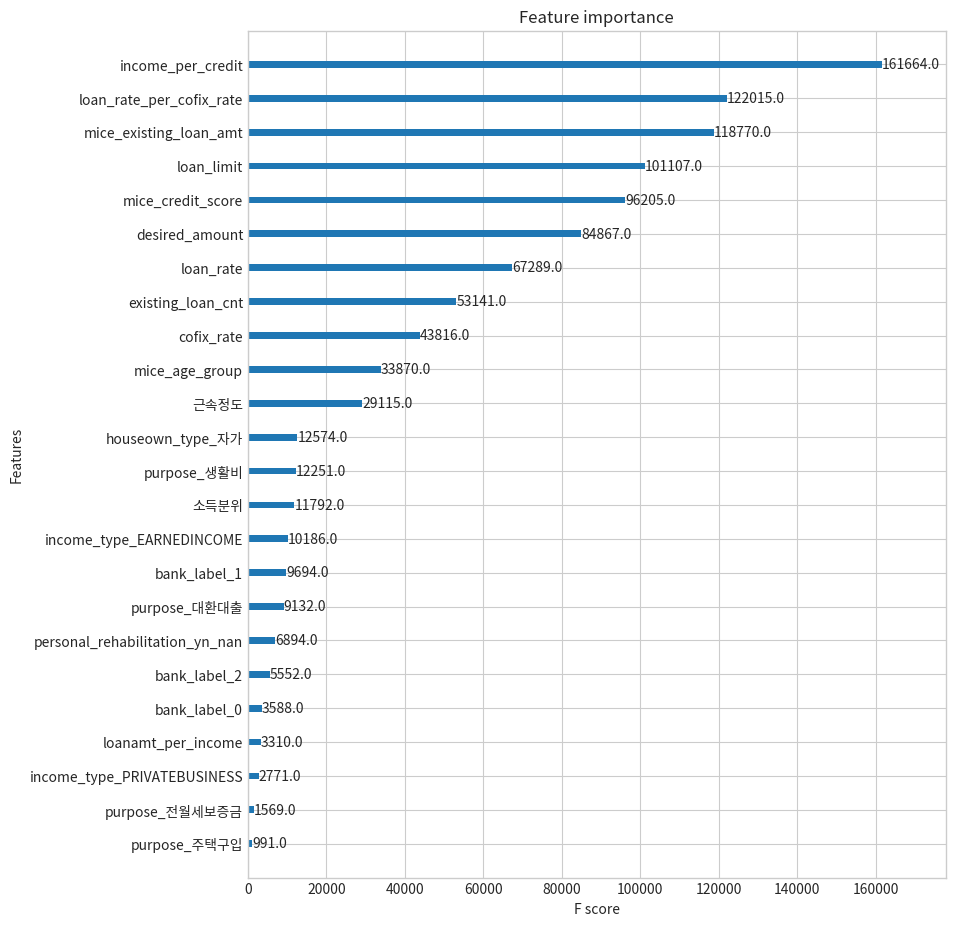

✅ shap


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


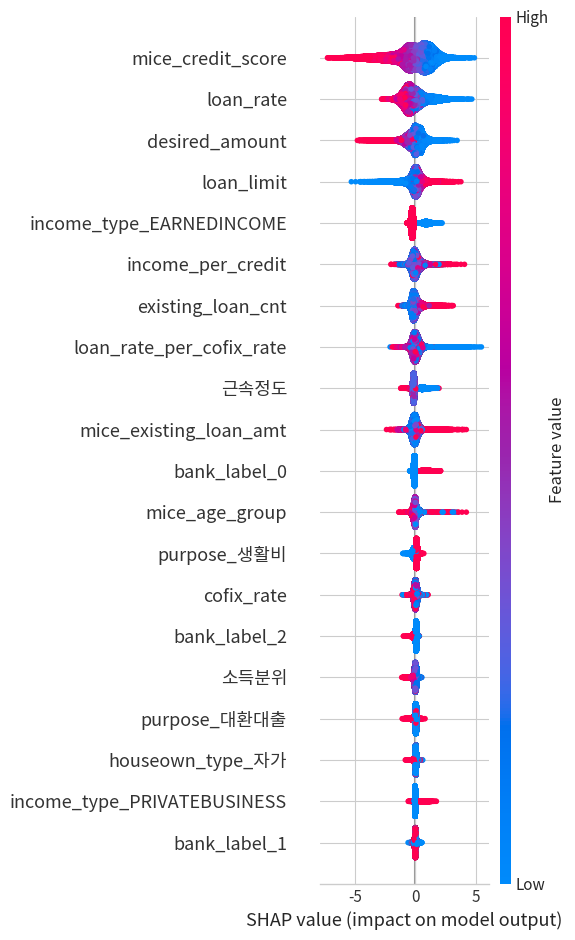

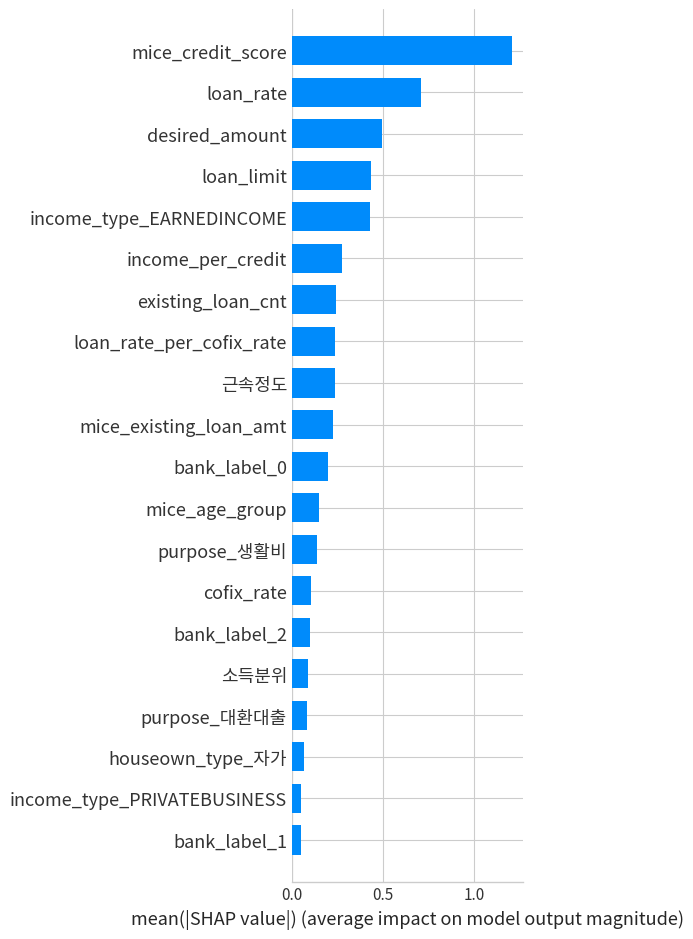

In [23]:
# XGB
downsampled_df = down_sampling(pred_train_df) 
train_X, valid_X, train_Y, valid_Y = split_train_valid(downsampled_df)
print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)

random_state = None
model = XGB(train_X, train_Y,valid_X, valid_Y, random_state)
trained_model = model.model_train()
xgb_pred = model.pred_testset(test_X,trained_model)
# confusion_matrix
model.confusion_matrix(trained_model)
# permutation_importance
model.permutation_importance(trained_model)
# feature_importance
model.feature_importance(trained_model)
# shap
model.shap(trained_model)

Train과 Valid로 나누는 중...
(887537, 24) (887537,)
(221885, 24) (221885,)
✅ model_train


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


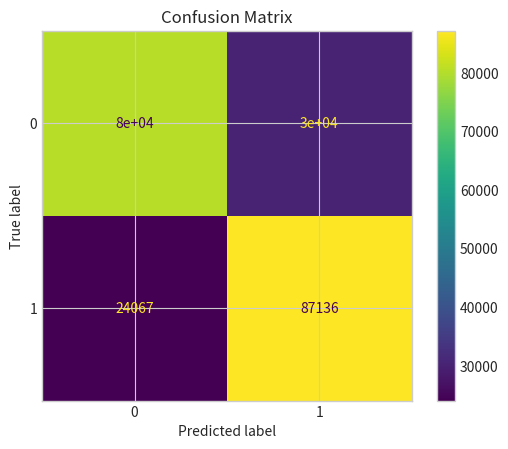

✅ permutation_importance


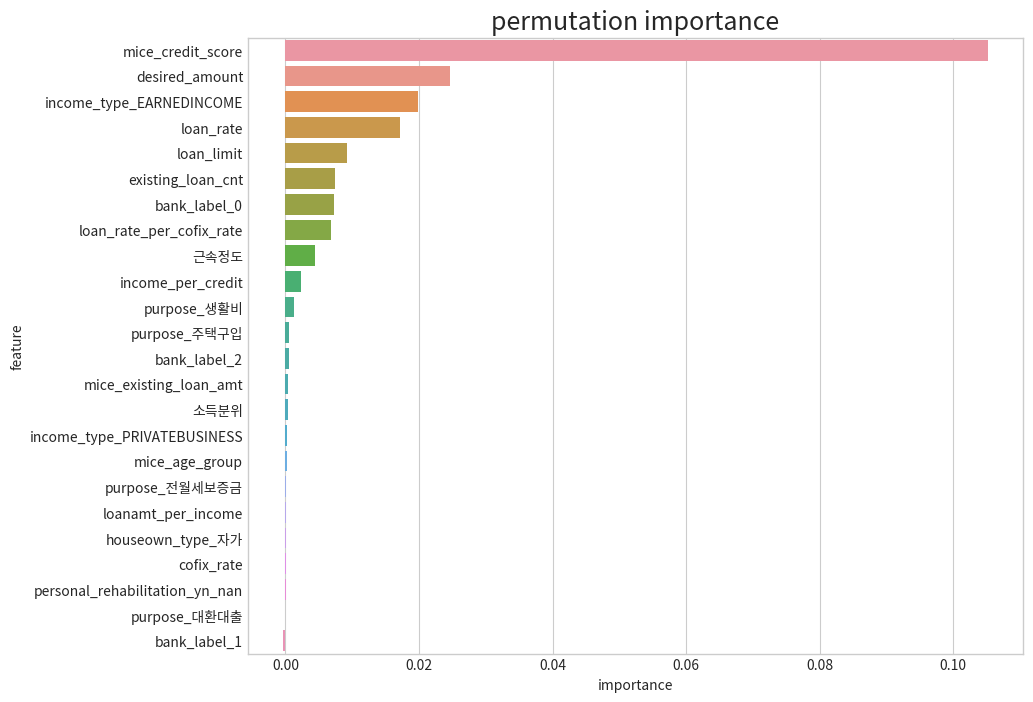

✅ feature_importance


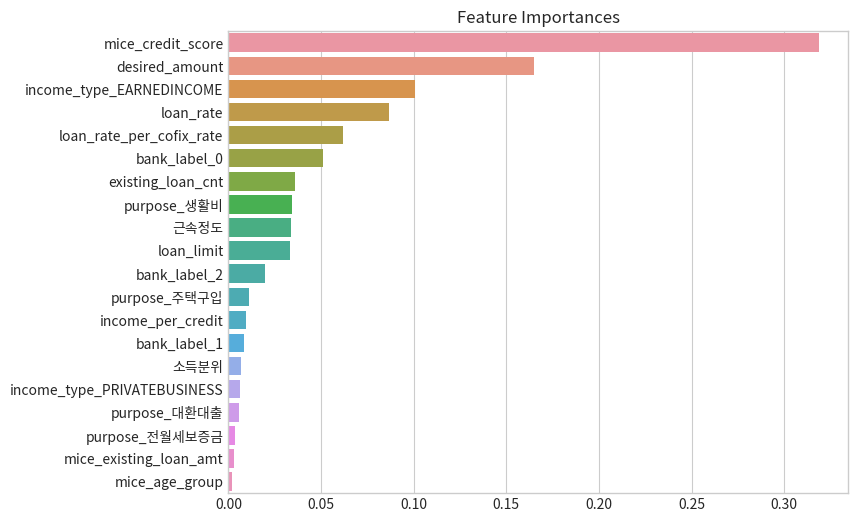

✅ shap


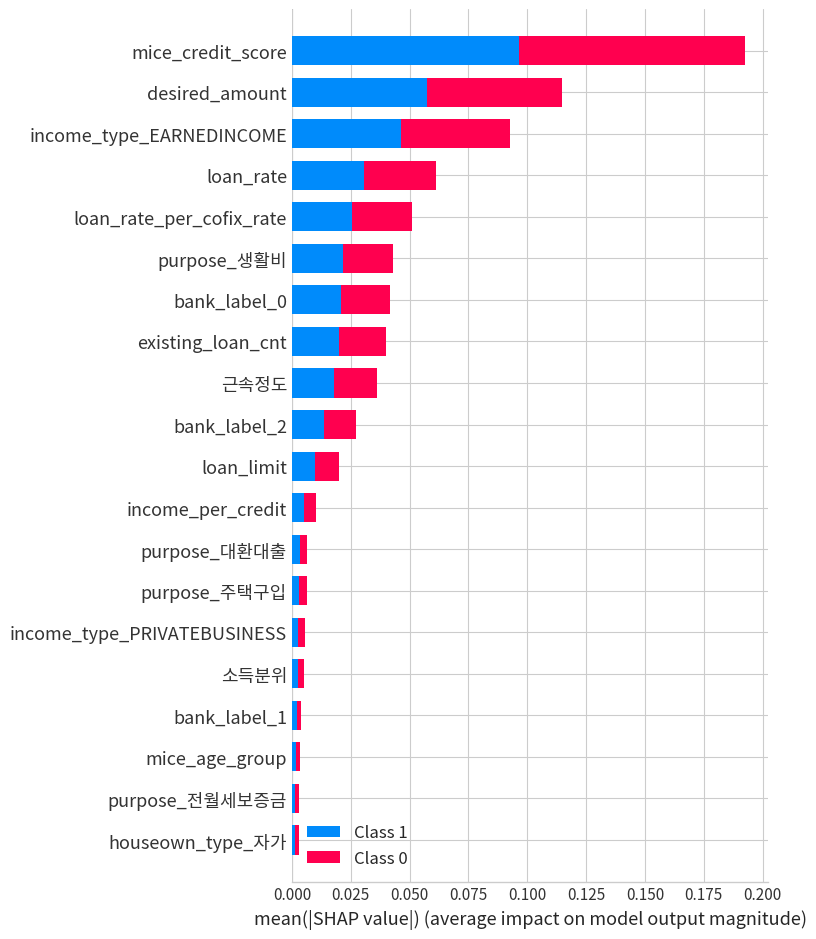

In [30]:
# RF
downsampled_df = down_sampling(pred_train_df) 
train_X, valid_X, train_Y, valid_Y = split_train_valid(downsampled_df)
print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)

random_state = None

model = RF(train_X, train_Y, valid_X, valid_Y, random_state)
trained_model = model.model_train()
rf_pred = model.pred_testset(test_X,trained_model)
# confusion_matrix
model.confusion_matrix(trained_model)
# permutation_importance
model.permutation_importance(trained_model)
# feature_importance
model.feature_importance(trained_model)
# shap
model.shap(trained_model)

In [39]:
# result hard voting
test_X['lgbm_pred'] = lgbm_pred
test_X['xgb_pred'] = xgb_pred
test_X['rf_pred'] = rf_pred

def most_frequent(a,b,c):
    data = [a,b,c]
    return max(data, key=data.count)

test_X['is_applyed'] = test_X.apply(lambda x : most_frequent(x['lgbm_pred'], x['xgb_pred'], x['rf_pred']), axis=1)
test_X['application_id'] = final_test_df['application_id']
test_X['user_id'] = final_test_df['user_id']

## Finalize result

In [43]:
result_df = pd.read_csv('./data/result/데이터분석분야_퓨처스부문_평가데이터.csv')

In [45]:
test_X.shape

(3255482, 31)

In [44]:
result_df.shape

(3255194, 3)

In [ ]:
result_df

In [ ]:
result_df = result_df.merge(test_X, on=['user_id', 'application_id'], how = 'left')

In [ ]:
result_df.isna().sum()